In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from app.utils.backtesting_utils import get_rsi

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="META"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_rsi = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

period = 7
df_rsi, df_crossovers = get_rsi(df_rsi, period)

In [4]:
df_rsi.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,rsi,position,returns,strategy
date_reference,,,,,,,,,,
2025-10-17,META,716.915,718.54,706.12,707.075,12232441,46.647805,1,0.006781,0.006781
2025-10-20,META,732.170,733.77,720.18,721.190,8900204,58.326314,1,0.021055,0.021055
2025-10-21,META,733.270,738.50,728.75,736.015,7647269,59.079842,1,0.001501,0.001501
2025-10-22,META,733.410,740.60,724.03,733.830,8734491,59.189412,1,0.000191,0.000191
2025-10-23,META,734.000,742.41,733.10,734.700,9855974,59.719709,1,0.000804,0.000804


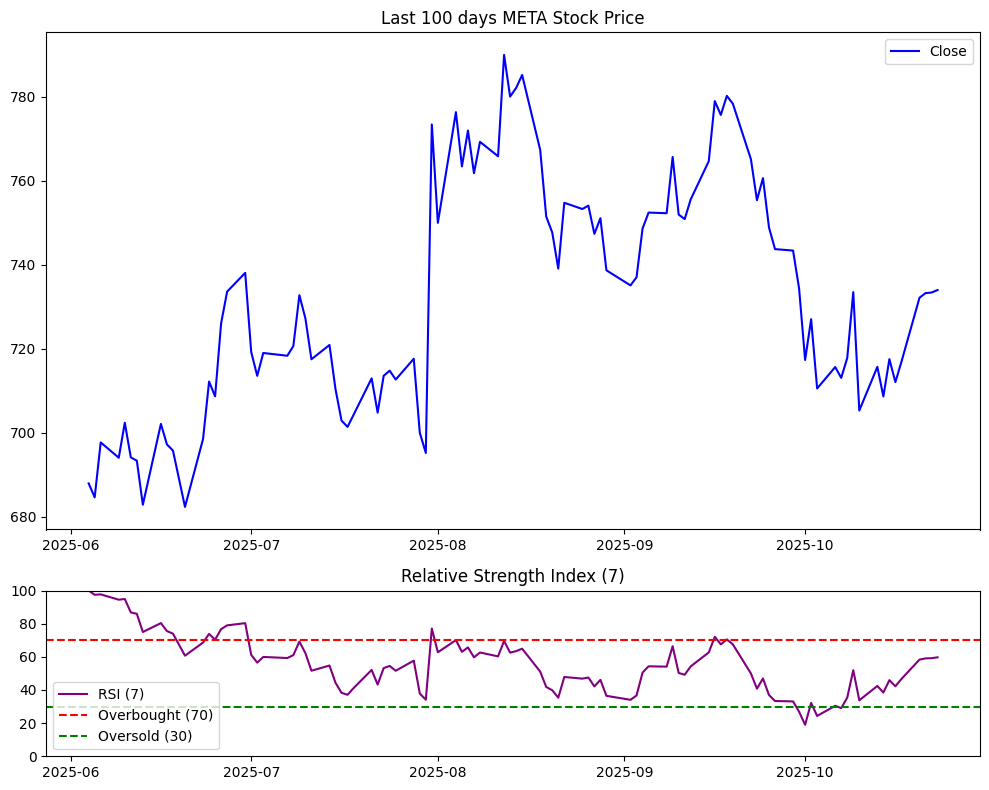

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_rsi.index, df_rsi['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: RSI plot
axs[1].plot(df_rsi.index, df_rsi['rsi'], label=f"RSI ({period})", color='purple')
axs[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axs[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axs[1].set_title(f"Relative Strength Index ({period})")
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

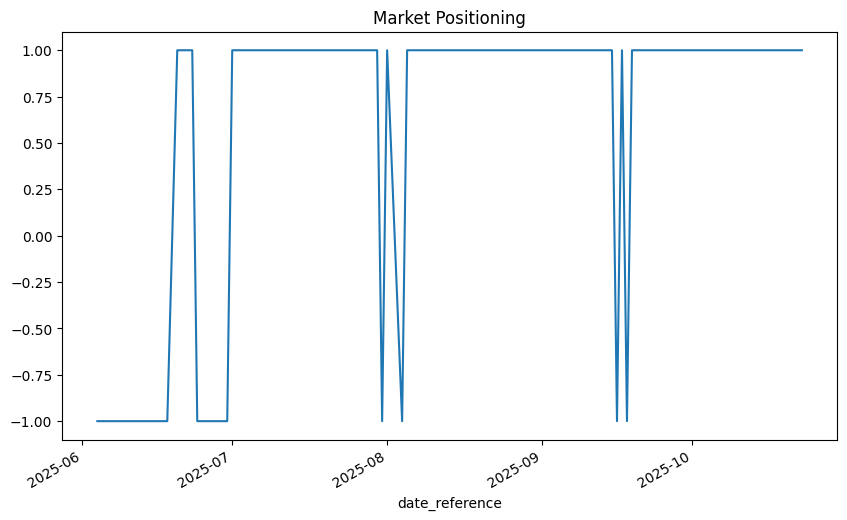

In [6]:
df_rsi['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [7]:
df_rsi[['returns', 'strategy']].sum().apply(np.exp)

returns     1.100697
strategy    1.222606
dtype: float64

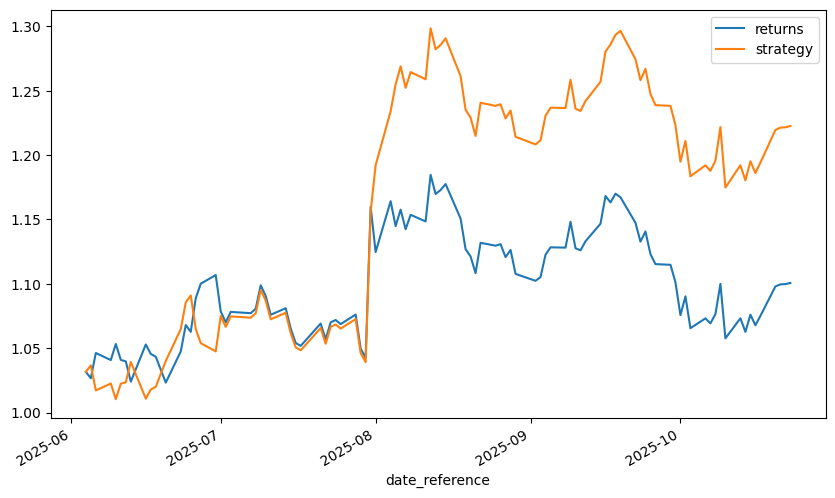

In [8]:
df_rsi[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [9]:
df_rsi['prev_rsi'] = df_rsi['rsi'].shift(1)
crossovers = df_rsi[
    ((df_rsi['rsi'] > 70) & (df_rsi['prev_rsi'] <= 70)) |  # Enter overbought (sell signal)
    ((df_rsi['rsi'] < 30) & (df_rsi['prev_rsi'] >= 30))    # Enter oversold (buy signal)
]
print(crossovers[['val_close', 'rsi', 'position']])

                val_close        rsi  position
date_reference                                
2025-06-24         712.20  73.838998        -1
2025-07-31         773.44  77.078045        -1
2025-08-04         776.37  70.066750        -1
2025-09-16         779.00  72.082717        -1
2025-09-18         780.25  70.525004        -1
2025-09-30         734.38  26.885218         1
2025-10-03         710.56  24.348890         1
2025-10-07         713.08  29.081899         1
